# Milky Way Satellite Maps

Author: Alex Drlica-Wagner

This notebook develops the survey footprint maps for LSST including flags for various foregrounds. There is a memory leak somewhere, so creating the high resolution figures can gobble up memory (hence the calls to the garbage collector). This notebook produces Figures 1 and 7 of [Tsiane et al. (2025)](https://arxiv.org/abs/2504.16203). 

In [1]:
import os
from os.path import splitext, basename

import numpy as np
import pylab as plt
import healsparse as hsp
import healpy as hp
import copy

from collections import OrderedDict as odict
from mpl_toolkits.axes_grid1 import make_axes_locatable

import skyproj

#plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "cmr10"
plt.rcParams["axes.formatter.use_mathtext"] = True
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16

In [2]:
# Load the subhalo_satellite_connection module
SATSIM = "/project/shared/data/satsim"
MODEL = f"{SATSIM}/dc2_paper/subhalo_satellite_connection"
os.environ["RUBIN_SIM_DATA_DIR"] = f"{SATSIM}/rubin_sim_data"

from rubin_sim import maf
from rubin_sim.data import get_data_dir
from rubin_sim.data import get_baseline

In [3]:
# From 2020 MW census (coming from masks.py)

BITS = odict([
    ('GOOD',   0b000000000), # No flags                                                                                                    
    ('DWARF4', 0b000000001), # near known dwarf (type2 >= 4)                                                                               
    ('DWARF3', 0b000000010), # near known dwarf (type2 == 3)
    ('ASSOC',  0b000000100), # near object in catalogs (excluding DWARFs)                                                                  
    ('STAR',   0b000001000), # near bright star                                                                                            
    ('EBV',    0b000010000), # E(B-V) > 0.2                                                                                                
    ('FOOT',   0b000100000), # outside of footprint                                                                                        
    ('FAIL',   0b001000000), # location of failure in ugali PS1 processing                                                                 
    ('ART',    0b010000000), # location of artifact in PS1 footprint                                                                       
])

# Add LSST-specific bits
BITS['SHALLOW'] = 0b100000000 # predicted LSST depth too shallow

print('\n'.join([f'{k}: {v}' for k,v in BITS.items()]))

GOOD: 0
DWARF4: 1
DWARF3: 2
ASSOC: 4
STAR: 8
EBV: 16
FOOT: 32
FAIL: 64
ART: 128
SHALLOW: 256


In [4]:
def celToGal(ra, dec):
    """
    Converts Celestial J2000 (deg) to Galactic (deg) coordinates
    """
    dec = np.radians(dec)
    sin_dec = np.sin(dec)
    cos_dec = np.cos(dec)

    ra = np.radians(ra)    
    ra_gp = np.radians(192.85948)
    de_gp = np.radians(27.12825)

    sin_ra_gp = np.sin(ra - ra_gp)
    cos_ra_gp = np.cos(ra - ra_gp)

    lcp = np.radians(122.932)    
    sin_b = (np.sin(de_gp) * sin_dec) \
            + (np.cos(de_gp) * cos_dec * cos_ra_gp)
    lcpml = np.arctan2(cos_dec * sin_ra_gp,
                          (np.cos(de_gp) * sin_dec) \
                          - (np.sin(de_gp) * cos_dec * cos_ra_gp))
    bb = np.arcsin(sin_b)
    ll = (lcp - lcpml + (2. * np.pi)) % (2. * np.pi)
    return np.degrees(ll), np.degrees(bb)

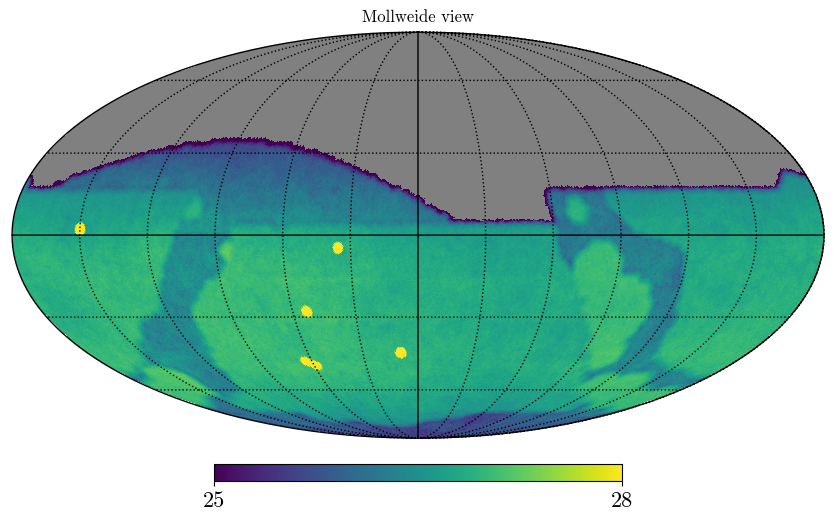

In [5]:
# Here is a look at one of the old maps Peter generated
filename = f'{MODEL}/Classifier/3-3_10_year_depth_g_nside_128.hs'
hspmap = hsp.HealSparseMap.read(filename)
hpxmap = hspmap.generate_healpix_map()
hp.mollview(hpxmap,nest=True,min=25,max=28)
hp.graticule()

## Create Depth Map from Rubin Sims

Convert rubin_sims depth maps to healpix.

## Comparison between DC2 and LSST sims baseline

This is a comparison of the depth between LSST sims and the DC2.

In [6]:
g_dc2=hsp.HealSparseMap.read(f"{SATSIM}/supreme_dc2_dr6d_v3_g_maglim_psf_wmean.hs")
r_dc2=hsp.HealSparseMap.read(f"{SATSIM}/supreme_dc2_dr6d_v3_r_maglim_psf_wmean.hs")

nside=128
g_dc2_hpxmap = g_dc2.generate_healpix_map(nside=nside,nest=False)
r_dc2_hpxmap = r_dc2.generate_healpix_map(nside=nside,nest=False)

g_dc2

HealSparseMap: nside_coverage = 32, nside_sparse = 32768, float64, 94340127 valid pixels

In [7]:
# From the native healsparse
#maglim_g = np.median(g_dc2[g_dc2.valid_pixels])
#maglim_r = np.median(r_dc2[r_dc2.valid_pixels])

# From the low-res healpix
maglim_g = np.median(g_dc2_hpxmap[g_dc2_hpxmap > 0])
maglim_r = np.median(r_dc2_hpxmap[r_dc2_hpxmap > 0])

print(f"S/N = 10 maglim (g): {maglim_g:.3f}")
print(f"S/N = 10 maglim (r): {maglim_r:.3f}")

print(f"S/N = 5 maglim (g): {maglim_g + 2.5*np.log10(2):.2f}")
print(f"S/N = 5 maglim (r): {maglim_r + 2.5*np.log10(2):.2f}")

S/N = 10 maglim (g): 26.963
S/N = 10 maglim (r): 26.839
S/N = 5 maglim (g): 27.72
S/N = 5 maglim (r): 27.59


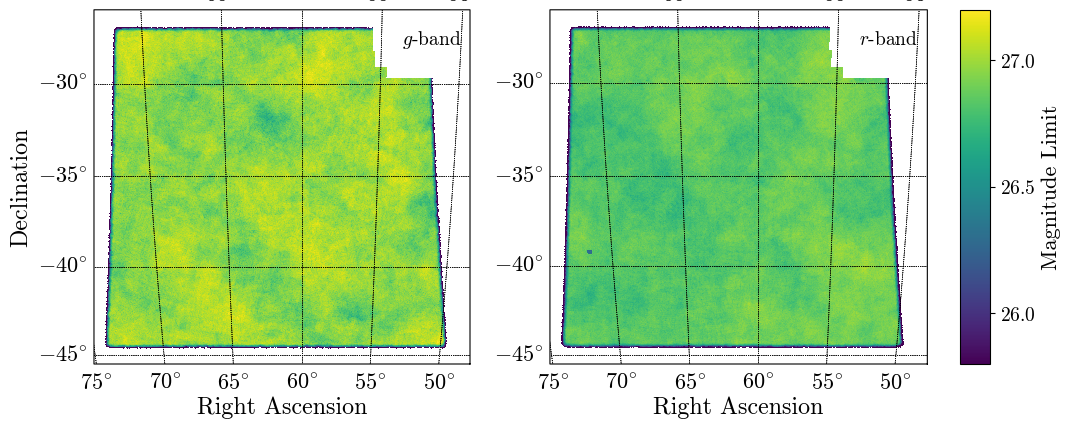

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,4.6))                     
plt.subplots_adjust(left=0.15, right=0.9, wspace=0.03)

# Depth maps
kw = dict(vmin=25.8, vmax=27.2)
sp = skyproj.McBrydeSkyproj(ax=ax[0], lon_0=60)
im, _, _, _ = sp.draw_hspmap(g_dc2, **kw)
sp.ax.annotate('$g$-band', (0.82,0.9), xycoords='axes fraction', fontsize=14)

sp = skyproj.McBrydeSkyproj(ax=ax[1], lon_0=60)
im, _, _, _ = sp.draw_hspmap(r_dc2, **kw)
sp.ax.annotate('$r$-band', (0.82,0.9), xycoords='axes fraction', fontsize=14)
sp.ax.set_ylabel('')

# Colorbar
cax = fig.add_axes([0.9, 0.11, 0.025, 0.77])
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label(label='Magnitude Limit', size=16)
cax.set_yticks([26, 26.5, 27.0])
cax.tick_params(labelsize=14)

plt.savefig("dc2_gr_depth_maps.pdf")

In [9]:
hpxmap_r = hp.read_map('baseline_v4.0_year_10_band_r_nside_128.fits')
sel = (r_dc2_hpxmap > 0)
hpxmap_r[sel] = r_dc2_hpxmap[sel]

hpxmap_g = hp.read_map('baseline_v4.0_year_10_band_g_nside_128.fits')
sel = (g_dc2_hpxmap > 0)
hpxmap_g[sel] = g_dc2_hpxmap[sel]

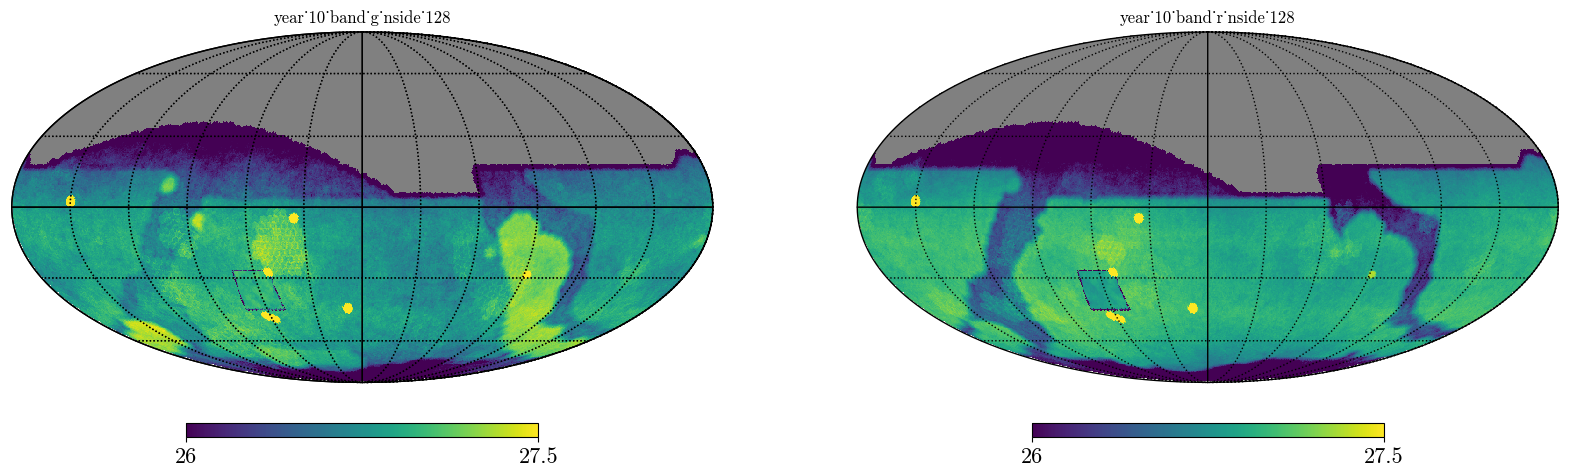

In [10]:
fig, ax = plt.subplots(1,2, figsize=(20,10)) 
plt.sca(ax[0])
hp.mollview(hpxmap_g,min=26.0,max=27.5, title='year_10_band_g_nside_128',hold=True)
hp.graticule()

plt.sca(ax[1])
hp.mollview(hpxmap_r,min=26.0,max=27.5, title='year_10_band_r_nside_128',hold=True)
hp.graticule()

## Generate LSST Mask

Create the masks for applying the SSFs. Note that mask = 0 is considered "good".

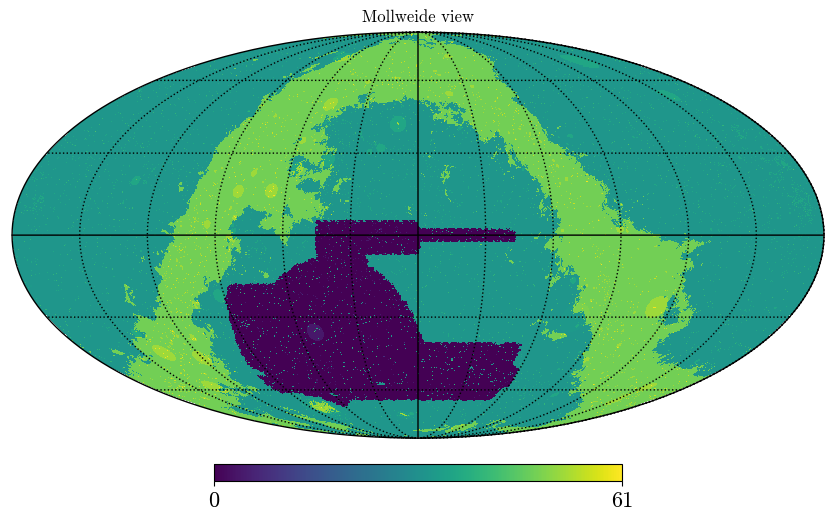

In [11]:
# Take a look at the DES mask; this is used for other mask bits
filename='../Classifier/healpix_mask_des_v5.1.fits'
des_mask = hp.read_map(filename, nest=True)
hp.mollview(des_mask, nest=True)
hp.graticule()

Creating LSST footprint mask...
Writing LSST footprint mask: healpix_mask_lsst_v3.1.fits


Footprint Area: 18264.16182364992 deg2


28702

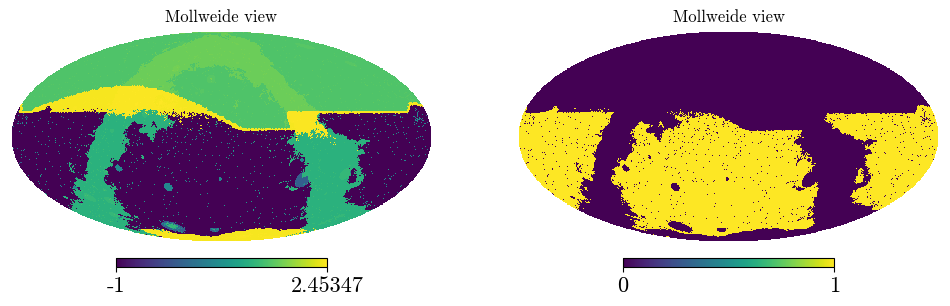

In [12]:
#Create the LSST footprint mask
print("Creating LSST footprint mask...")

nside=4096
maglim = 26.0

# Load the baseline depth map
hpxmap_g = hp.read_map('baseline_v4.0_year_10_band_g_nside_128.fits', nest=True)
hpxmap_r = hp.read_map('baseline_v4.0_year_10_band_r_nside_128.fits', nest=True)

# Create the bit mask
lsst_mask = BITS['FOOT']*np.ones(len(hpxmap), dtype=np.int16)
# In the footprint and deeper than maglim
sel = (hpxmap_g >= maglim) & (hpxmap_r >= maglim)
lsst_mask[sel] = BITS['GOOD']
# In the footprint and shallower
sel = ((hpxmap_g > 0) & (hpxmap_g < maglim)) | ((hpxmap_r > 0) & (hpxmap_r < maglim))
lsst_mask[sel] = BITS['SHALLOW']

lsst_mask = hp.ud_grade(lsst_mask, nside_out=nside, order_in='NEST', order_out='NEST')

# Apply mask bits from 2020 Census
des_mask = hp.read_map('../Classifier/healpix_mask_des_v5.1.fits', nest=True)                                     
for bit in ['DWARF4', 'DWARF3', 'ASSOC', 'STAR', 'EBV']:
    flag = np.where(des_mask & BITS[bit], True, False)
    lsst_mask[flag] |= BITS[bit]
del des_mask, flag

# Write the mask
outfile = 'healpix_mask_lsst_v3.1.fits'
print(f"Writing LSST footprint mask: {outfile}")
hp.write_map(outfile, lsst_mask, nest=True, overwrite=True)

fig, ax = plt.subplots(1,2,figsize=(12,4))
plt.sca(ax[0]); hp.mollview(np.log10(lsst_mask + 0.1), nest=True, hold=True)
plt.sca(ax[1]); hp.mollview(lsst_mask == BITS['GOOD'], nest=True, hold=True)

pixarea = hp.nside2pixarea(nside, degrees=True)
print(f"Footprint Area: {(lsst_mask == BITS['GOOD']).sum()*pixarea} deg2")

del lsst_mask, sel

import gc; gc.collect()

Footprint Area: 18264.16182364992 deg2


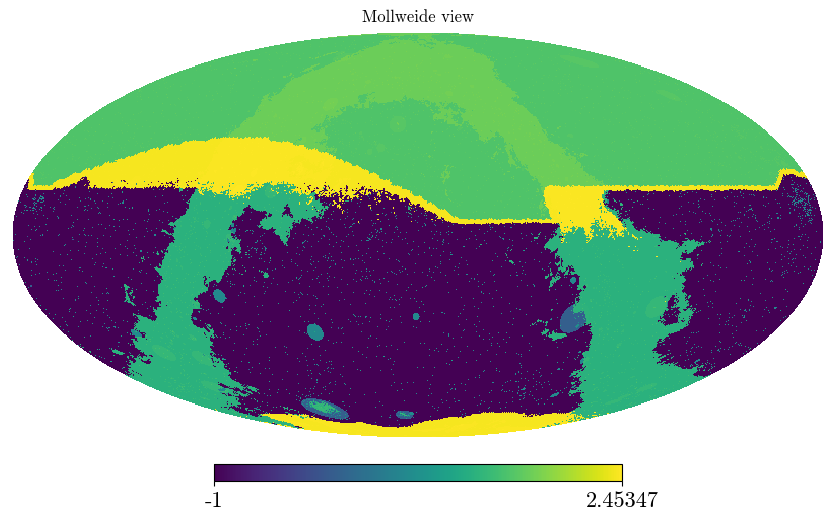

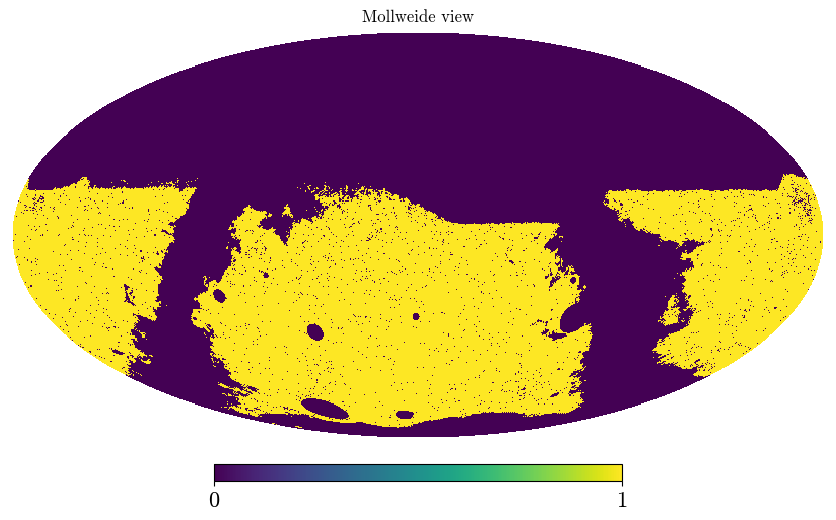

In [13]:
# Plot the LSST mask and calculate area
filename = 'healpix_mask_lsst_v3.1.fits'
lsst_mask = hp.read_map(filename, nest=True)

hp.mollview(np.log10(lsst_mask + 0.1), nest=True)
hp.mollview(lsst_mask == BITS['GOOD'], nest=True)

pixarea = hp.nside2pixarea(nside, degrees=True)
print(f"Footprint Area: {(lsst_mask == BITS['GOOD']).sum()*pixarea} deg2")

## Plot LSST Mask

Plot the mask for the paper

In [14]:
# Custom color map for plotting, based on 'ocean'
n = 4
base = plt.get_cmap('ocean_r')
cl = base(np.linspace(0,1,n))
color_list = [cl[0], cl[3], cl[1], cl[2]] # Swap green before the blues
color_list[3] = np.array([0., 0, 0.25, 1.]) # Make the dark blue darker
new_cmap = base.from_list('new_cmap', color_list, n)

def simplify_mask(healpix_mask):
    #simplified_mask = np.zeros_like(healpix_mask)
    simplified_mask = np.copy(healpix_mask)

    # Catalog associations
    cut_catalog = np.zeros_like(simplified_mask)
    for bit in ['ASSOC', 'STAR'] + [f'DWARF{i}' for i in [4, 3, 2]]:
        if bit not in BITS: continue
        cut_catalog |= (simplified_mask & BITS[bit])
    cut_catalog = np.where(cut_catalog)

    # Reddening
    cut_ebv = np.where(simplified_mask & BITS['EBV'])
    # Footprint
    cut_footprint = np.zeros_like(simplified_mask)
    for bit in ['FOOT', 'FAIL', 'ART', 'SHALLOW']:
        if bit not in BITS: continue
        cut_footprint |= (simplified_mask & BITS[bit])
    cut_footprint = np.where(cut_footprint)

    simplified_mask[:] = 0
    simplified_mask[cut_catalog] = 1
    simplified_mask[cut_ebv] = 2
    simplified_mask[cut_footprint] = 3
    return simplified_mask

def plot_mask(survey, mask, use_skyproj=True):
    print("Loading mask and simplifying the mask for plotting...")
    simplified_mask = simplify_mask(mask)

    title = ''
    fig, ax = plt.subplots(figsize=(12,8))                     

    if use_skyproj:
        # Using skyproj
        import skyproj

        sp = skyproj.McBrydeSkyproj(ax=ax, longitude_ticks='symmetric')
        sp.draw_hpxmap(simplified_mask, cmap=new_cmap, nest=True)
        sp.ax.tick_params(axis='both', which='major', labelsize=20)

        #sp.ax.tick_params(axis="x", labelsize=20)
        cbar = plt.colorbar(plt.gci(), ticks = (np.arange(n) + 0.5)*(n-1)/n, fraction=0.02)
        cbar.set_ticklabels(['Unmasked', 'Association', r'$E(B-V) > 0.2$', 'Footprint'])
        plt.title(title)

    else:
        # Using mollview
        hp.mollview(simplified_mask, nest=True, coord='C', cmap=new_cmap, title=title, xsize=1600, hold=True)
        ax = plt.gca()
        cbar = plt.gci().colorbar
        cbar.set_ticks( (np.arange(n) + 0.5)*(n-1)/n )
        cbar.set_ticklabels(['Unmasked', 'Association', r'$E(B-V) > 0.2$', 'Footprint'])
        hp.graticule()

    plt.savefig('healpix_mask_{}.pdf'.format(survey))
    #plt.close()

Loading mask and simplifying the mask for plotting...


13728

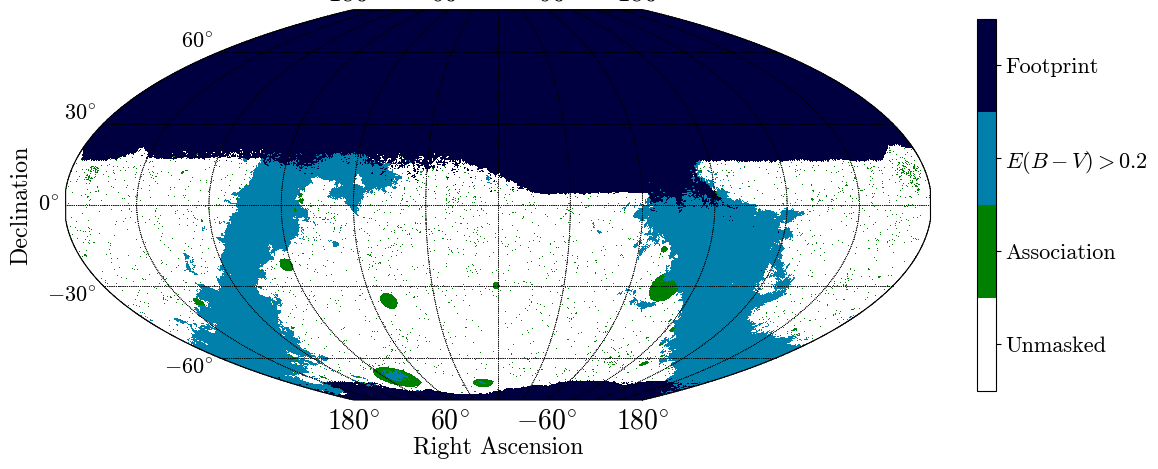

In [15]:
#des_mask = hp.read_map('../Classifier/healpix_mask_des_v5.1.fits', nest=True)
#plot_mask('des', des_mask)
#ps1_mask = hp.read_map('../Classifier/healpix_mask_ps1_v5.1.fits', nest=True)
#plot_mask('ps1', ps1_mask)

#lsst_mask = hp.read_map('healpix_mask_lsst_v3.1.fits', nest=True)
plot_mask('lsst', lsst_mask)

import gc; gc.collect()

# BIT Mask investigation

Investigate the various bit masks.